# Predict whether a patient who is suffering COVID-19 by looking at their chest X-ray

Data source: 
- [Covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset)

## Setup

Download data into `data` directory
```
git clone https://github.com/ieee8023/covid-chestxray-dataset.git ../data
```


Load required libraries

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd

## Step 1: Load data into an `ImageBunch` object

In [5]:
# read the metadata.csv file
path = Path('../data')
metadata = pd.read_csv(path/'metadata.csv')
metadata.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes
0,2,0.0,M,65.0,COVID-19,Y,Y,N,N,N,...,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
1,2,3.0,M,65.0,COVID-19,Y,Y,N,N,N,...,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
2,2,5.0,M,65.0,COVID-19,Y,Y,N,N,N,...,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
3,2,6.0,M,65.0,COVID-19,Y,Y,N,N,N,...,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN
4,4,0.0,F,52.0,COVID-19,Y,NaN,N,N,N,...,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN


In [6]:
# create label column
metadata['label'] = metadata.finding.isin(['COVID-19'])
metadata.label.value_counts()

True     550
False    336
Name: label, dtype: int64

In [9]:
# create name column
metadata['name'] = metadata.folder + os.path.sep + metadata.filename

# filter out X-rays
df = metadata.loc[metadata['modality']=='X-ray',['name','label']]
df.head()

,name,label
0,images/auntminnie-a-2020_01_28_23_51_6665_2020...,True
1,images/auntminnie-b-2020_01_28_23_51_6665_2020...,True
2,images/auntminnie-c-2020_01_28_23_51_6665_2020...,True
3,images/auntminnie-d-2020_01_28_23_51_6665_2020...,True
4,images/nejmc2001573_f1a.jpeg,True


In [16]:
# create ImageBunch object from dataframe
bs = 64
data = ImageDataBunch.from_df(path=path, 
                              df=df, 
                              ds_tfms=get_transforms(),
                              size=224, 
                              bs=bs).normalize(imagenet_stats)
data.classes

[False, True]

In [25]:
# no. of images in train and validation sets
len(data.train_ds), len(data.valid_ds)

(642, 160)

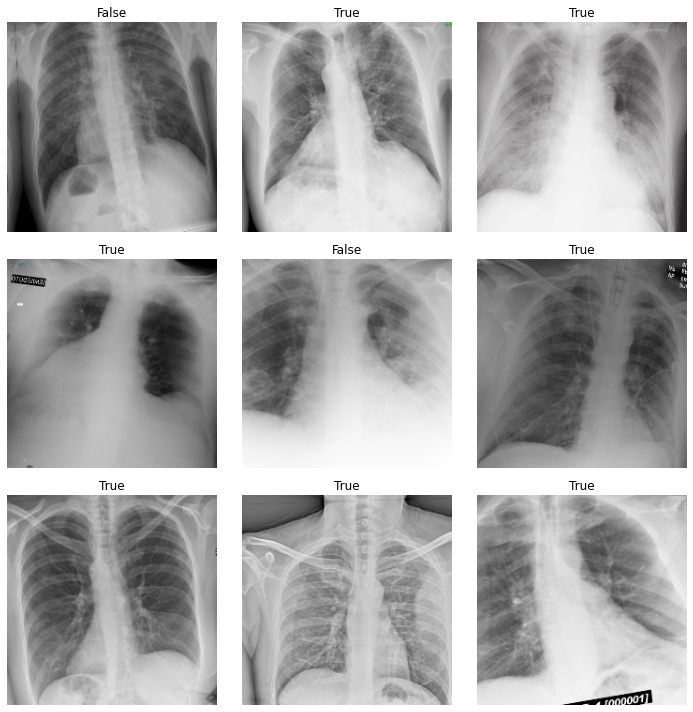

In [19]:
data.show_batch(rows=3, figsize=(10,10))

Looks good, let us create our learner

## Step 2: Train a Convolution Neural Network using [ResNet50](https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.resnet50) architecture

In [20]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.162441,0.624096,0.243750,00:23
1,1.081636,0.890454,0.287500,00:20
2,1.001858,1.014678,0.318750,00:20
3,0.900696,0.736694,0.281250,00:21
4,0.806296,0.666744,0.231250,00:21
5,0.721574,0.599888,0.243750,00:19
6,0.675213,0.565425,0.237500,00:19
7,0.633387,0.552963,0.250000,00:19


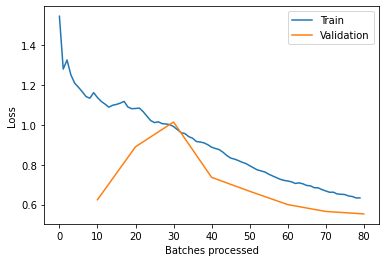

In [23]:
learn.recorder.plot_losses()

Train loss is higher than validation loss, suggesting we can try training a few more epochs..

In [27]:

# save this stage
learn.save('covid-cxr-stage-1-50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


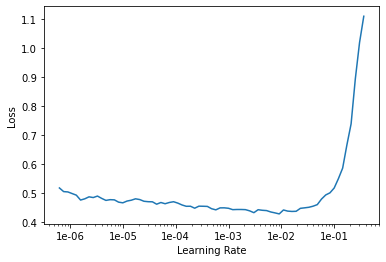

In [26]:
# let us try to find optimum learning rate
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.452256,0.544096,0.243750,00:20
1,0.466195,0.540157,0.250000,00:20
2,0.442363,0.541143,0.243750,00:19
3,0.437391,0.529092,0.237500,00:20
4,0.437051,0.538296,0.243750,00:19
5,0.420750,0.535231,0.250000,00:19
6,0.411298,0.520680,0.268750,00:20
7,0.392307,0.514235,0.256250,00:20
8,0.378643,0.502615,0.237500,00:21
9,0.366904,0.505818,0.243750,00:20


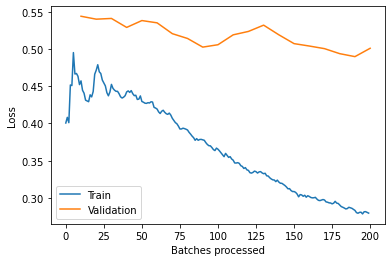

In [35]:
learn.recorder.plot_losses()

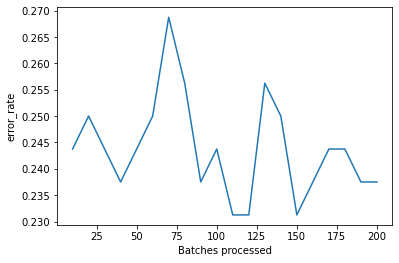

In [34]:
learn.recorder.plot_metrics()

Looks good


In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

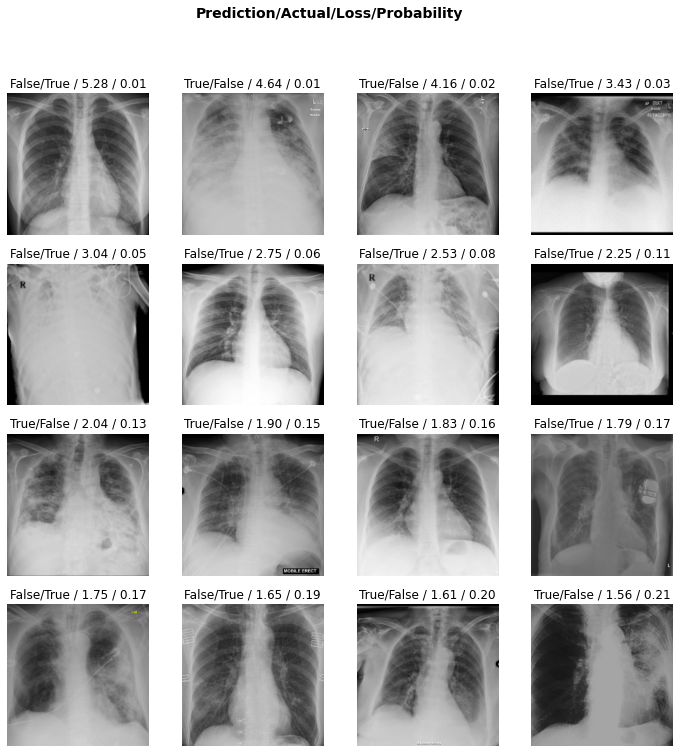

In [61]:
interp.plot_top_losses(16)

In [56]:
learn.save('covid-cxr-stage-2-50')

# Next Steps

In the upcoming weeks we will try to improve the model performance by 
- data cleaning
- segmentation
- or maybe using more data
--